In [1]:
from brian2 import *

prefs.codegen.target = "numpy"

In [2]:
%%time
start_scope()

# morphology creation
cyl_len = 50 * umetre
cyl_diam = 50 * umetre
cylinder = Cylinder(length=cyl_len, diameter=cyl_diam, n=1, type="axon")

# consta and parameters
Cm = 1 * ufarad / cm**2
Eleak = -65.5 * mV
#Eleak = 0 * mV  # like in HH example
Vr = -57.4 * mV
gl = 1.42 * msiemens/cm**2
q10 = 3 ** ((20 - 6.3)/10)  # 20 stands for degree Celsius

gNa_f_max = 25 * msiemens/cm**2
gNa_l1_max = 27 * msiemens/cm**2
gNa_l2_max = 0.128 * msiemens/cm**2

ENa = 62 * mV

gK_max = 1.5 *msiemens/cm**2
EK = -94 * mV

# equations

main_eq = """
Im = gl * (Eleak - v) + INa_f + IK + INa_l1 + INa_l2 : amp/meter**2  # + INa_l2
I : amp (point current)
"""

Na_f_eq = """
INa_f = gNa_f_max * m_f**3 * h_f * (ENa - v) : ampere/meter**2

dm_f/dt = (m_f_inf - m_f) / tau_m_f : 1
m_f_inf = alpha_m / (alpha_m + beta_m) : 1
tau_m_f = 1*ms / (q10 * (alpha_m + beta_m)) : second  # modelDB version
alpha_m = 1 / exprel(-(v + 34*mV)/10/mV) : 1
beta_m = 4 * exp(-(v + 59*mV)/18/mV) : 1

dh_f/dt = (h_f_inf - h_f) / tau_h_f : 1
alpha_h_f = 0.07 * exp(-(v + 59*mV)/20/mV) : 1
beta_h_f = 1 / (exp(-(v + 29*mV)/10/mV) + 1) : 1
tau_h_f = 1*ms/(q10*(alpha_h_f + beta_h_f)) : second
h_f_inf = alpha_h_f / (alpha_h_f + beta_h_f) : 1
"""
Na_f_eq = Equations(Na_f_eq)
K_eq = """
IK = gK_max * n * (EK - v) : ampere/meter**2
dn/dt = (n_inf - n) / tau_n : 1
alpha_n = .1 / exprel(-(v + 55*mV)/10/mV) : 1
beta_n = 0.125 * exp(-(v + 65*mV)/80/mV) : 1
tau_n = 1*ms / (q10 * (alpha_n + beta_n)) : second
n_inf = alpha_n / (alpha_n + beta_n) : 1
"""
K_eq = Equations(K_eq)
Na_l1_eq = """
INa_l1 = gNa_l1_max * m_l1_inf * h_l1 * (ENa - v) : ampere/meter**2

alpha_m_l1 = 1 / exprel(-(v + 25*mV)/10/mV) : 1
beta_m_l1 = 4 * exp(-(v + 50*mV)/18/mV) : 1
m_l1_inf = alpha_m_l1 / (alpha_m_l1 + beta_m_l1) / q10 : 1

dh_l1/dt = (h_l1_inf - h_l1) / tau_h_l1 : 1
h_l1_inf = 1 / (1 + exp((v + 72.5*mV)/8/mV)) : 1
tau_h_l1 = 0.2218*ms * exp(-0.06883*v/mV) : second
"""
Na_l1_eq = Equations(Na_l1_eq)
Na_l2_eq = """
INa_l2 = gNa_l2_max * m_l2_inf * h_l2 * (ENa - v) : ampere/meter**2
m_l2_inf = 1 / (1 + exp((-51.8*mV - v)/4.6/mV)) : 1
dh_l2/dt = (h_l2_inf - h_l2) / tau_h_l2 : 1
tau_h_l2 = 1*ms / (0.04 * exp(v/25.5/mV)) + 63.2*ms : second
h_l2_inf = 0.9827 / (1 + exp(-((v + 55.67*mV)/(-6.552*mV)))) : 1
"""
Na_l2_eq = Equations(Na_l2_eq)
main_eq = Equations(main_eq) + Na_f_eq + Na_l1_eq + K_eq + Na_l2_eq


# neuron main object
neuron = SpatialNeuron(morphology=cylinder,
                    model=main_eq, Cm=Cm, Ri=100*ohm*cm,
                    method="exponential_euler")

# monitors
mon = StateMonitor(neuron, ['v', "m_l1_inf", "h_l1"], record=True)

neuron.v = -70*mV

for inp_cur in [0, .1, .5, 5]:
    neuron.I = inp_cur * nA
    run(5000*ms, report="text")
    neuron.I = 0*nA
    run(1000*ms)

Starting simulation at t=0. s for a duration of 5. s
0.451 s (9%) simulated in 10s, estimated 1m 41s remaining.
1.162 s (23%) simulated in 20s, estimated 1m 6s remaining.
1.8784 s (37%) simulated in 30s, estimated 50s remaining.
2.5882 s (51%) simulated in 40s, estimated 37s remaining.


KeyboardInterrupt: 

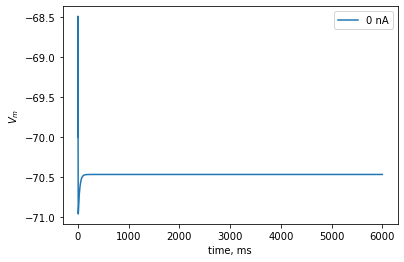

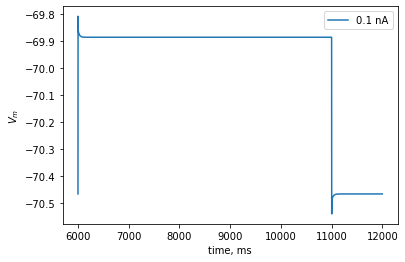

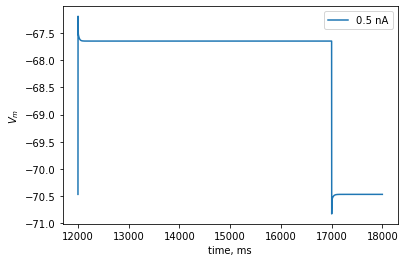

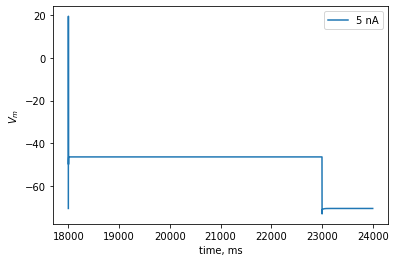

In [51]:
currs = [0, .1, .5, 5]
monshape = mon.t.shape[0]
simlen = monshape // 4

for cur_n in range(4):
    start = cur_n*simlen
    stop = start + simlen - 1
    figure()
    plot(mon.t[start:stop]/ms, mon.v[0][start:stop]/mV, label=f"{currs[cur_n]} nA")
    legend()
    xlabel("time, ms")
    ylabel("$V_m$")
    


Text(0, 0.5, '$V_m$, [mV]')

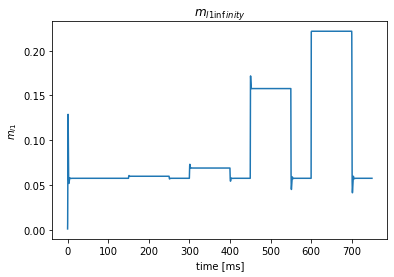

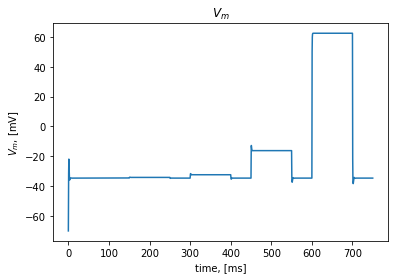

In [10]:
title("$m_{l1\infinity}$")
plot(mon.t/ms, mon.m_l1_inf[0])
xlabel("time [ms]")
ylabel("$m_{l1}$")

figure()
title("$V_m$")
plot(mon.t/ms, mon.v[0]/mV)
xlabel("time, [ms]")
ylabel("$V_m$, [mV]")

## supplementary

WARNING    /var/folders/dk/88m9s1b50v53bxqm50d17bjm0000gp/T/ipykernel_87314/1471473820.py:10: RuntimeWarning: invalid value encountered in power
  ttm = 0.1092 * exp(-0.5 * ((vv + 28.71)/25.5)**1.8)
 [py.warnings]


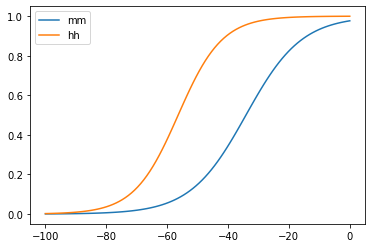

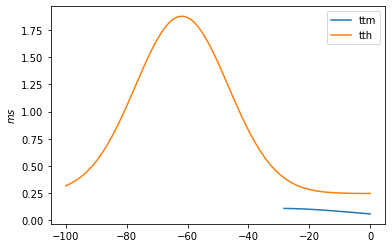

In [2]:
# Na fast
vv = linspace(-100, 0, 100)
mm = 1/(1 + exp((-34.12 - vv)/9.146))
hh = 1/(1 + exp((-56.39 - vv)/7.22))


plot(vv, mm, label='mm')
plot(vv, hh, label='hh')
legend()

ttm = 0.1092 * exp(-0.5 * ((vv + 28.71)/25.5)**1.8)
tth = 0.246 + 1.63 * exp(-0.5 * ((vv + 61.87)/15.25)**2)

figure()
plot(vv, ttm, label='ttm')
plot(vv, tth, label='tth')
ylabel("$ms$")
legend()

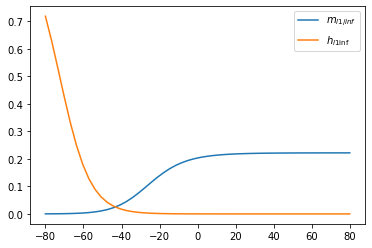

In [6]:
# inter (late1) current

vv = linspace(-80, 80)

alpha_m_l1 = 1 / exprel(-(vv + 25)/10)
beta_m_l1 = 4 * exp(-(vv + 50)/18)
m_l1_inf = alpha_m_l1 / (alpha_m_l1 + beta_m_l1) / q10

h_l1_inf = 1 / (1 + exp((72.5 + vv)/8))


plot(vv, m_l1_inf, label="$m_{l1/inf}$")
plot(vv, h_l1_inf, label="$h_{l1\inf}$")

legend()

In [21]:
%%time

start_scope()

morpho = Cylinder(length=10*cm, diameter=2*238*um, n=1000, type="axon")  # example original
#morpho = Cylinder(length=50*um, diameter=50*um, n=1000, type="axon")  # Kovalsky

El = 10.613*mV
ENa = 115*mV
EK = -12*mV
gl = 0.3*msiemens/cm**2
gNa0 = 120*msiemens/cm**2
gK = 36*msiemens/cm**2

eqs = """
Im = gl*(El-v) + gNa*m**3*h*(ENa - v) + gK * n**4 * (EK-v) : amp/meter**2
I : amp (point current)
dm/dt = alpham * (1-m) - betam * m : 1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz
betam = 4 * exp(-v/(18*mV))/ms : Hz
alphah = 0.07 * exp(-v/(20*mV))/ms : Hz
betah = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alphan = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
betan = 0.125*exp(-v/(80*mV))/ms : Hz
gNa : siemens/meter**2
"""

neuron = SpatialNeuron(morphology=morpho, model=eqs, Cm=1*uF/cm**2, Ri=35.4*ohm*cm, method="exponential_euler")

neuron.v = 0*mV
neuron.h = 1
neuron.m = 0
neuron.n = .5
neuron.gNa = gNa0
neuron.I = 0

M = StateMonitor(neuron, 'v', record=True)

for inp_cur in [0, .1, .5, 5, 25]:
    neuron.I = inp_cur * nA
    run(100*ms, report="text")
    neuron.I = 0*nA
    run(50*ms)

Starting simulation at t=0. s for a duration of 100. ms
29.5 ms (29%) simulated in 10s, estimated 24s remaining.
60. ms (60%) simulated in 20s, estimated 13s remaining.
91.1 ms (91%) simulated in 30s, estimated 3s remaining.
100. ms (100%) simulated in 32s
Starting simulation at t=150. ms for a duration of 100. ms
33.6 ms (33%) simulated in 10s, estimated 20s remaining.
66.7 ms (66%) simulated in 20s, estimated 10s remaining.
100. ms (100%) simulated in 29s
Starting simulation at t=300. ms for a duration of 100. ms
34.2 ms (34%) simulated in 10s, estimated 19s remaining.
67.6 ms (67%) simulated in 20s, estimated 10s remaining.
100. ms (100%) simulated in 29s
Starting simulation at t=0.45 s for a duration of 100. ms
32.7 ms (32%) simulated in 10s, estimated 21s remaining.
65.8 ms (65%) simulated in 20s, estimated 10s remaining.
99.6 ms (99%) simulated in 30s, estimated < 1s remaining.
100. ms (100%) simulated in 30s
Starting simulation at t=0.6 s for a duration of 100. ms
34. ms (33%) s

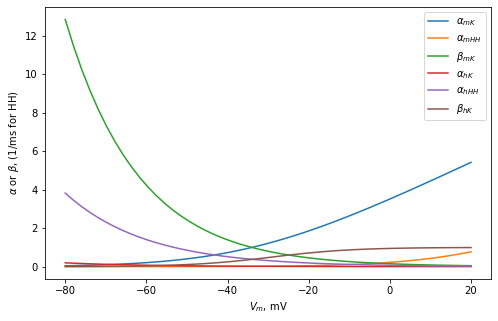

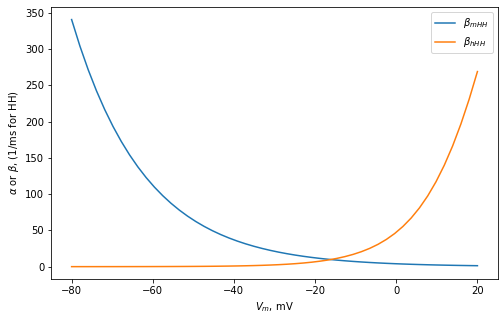

In [48]:
# equations comparison
v = linspace(-80, 20) * mV

alpha_m_K = 1 / exprel(-(v + 34*mV)/10/mV)
alpham_HH = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms #:Hz

beta_m_K = 4 * exp(-(v + 59*mV)/18/mV)
betam_HH = 4 * exp(-v/(18*mV))/ms #: Hz

alpha_h_f_K = 0.07 * exp(-(v + 59*mV)/20/mV)# : 1
alphah_HH = 0.07 * exp(-v/(20*mV))/ms# : Hz


beta_h_f_K = 1 / (exp(-(v + 29*mV)/10/mV) + 1)# : 1
betah_HH = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms# : Hz


figure(figsize=(8, 5))
plot(v/mV, alpha_m_K, label=r"$\alpha_{mK}$")
plot(v/mV, alpham_HH*ms, label=r"$\alpha_{mHH}$ ")
plot(v/mV, beta_m_K, label=r"$\beta_{mK}$")
#plot(v/mV, betam_HH*ms, label=r"$\beta_{mHH}$")
plot(v/mV, alpha_h_f_K, label=r"$\alpha_{hK}$")
plot(v/mV, alphah_HH*ms, label=r"$\alpha_{hHH}$")
plot(v/mV, beta_h_f_K, label=r"$\beta_{hK}$")
#plot(v/mV, betah_HH, label=r"$\beta_{hHH}$")

xlabel(r"$V_m$, mV")
ylabel(r"$\alpha$ or $\beta$, (1/ms for HH)")
legend()

figure(figsize=(8,5))
plot(v/mV, betam_HH*ms, label=r"$\beta_{mHH}$")
plot(v/mV, betah_HH, label=r"$\beta_{hHH}$")

xlabel(r"$V_m$, mV")
ylabel(r"$\alpha$ or $\beta$, (1/ms for HH)")
legend()

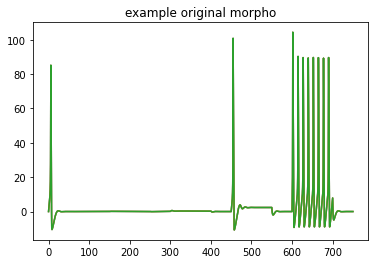

In [17]:
title("example original morpho")
plot(M.t/ms, M.v[0]/mV)
plot(M.t/ms, M.v[500]/mV)
plot(M.t/ms, M.v[-1]/mV)

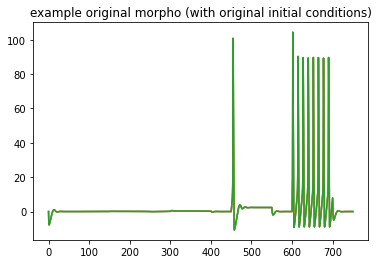

In [22]:
title("example original morpho (with original initial conditions)")
plot(M.t/ms, M.v[0]/mV)
plot(M.t/ms, M.v[500]/mV)
plot(M.t/ms, M.v[-1]/mV)

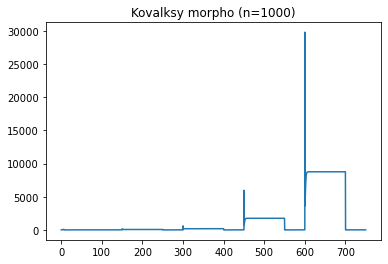

In [20]:
title("Kovalksy morpho (n=1000)")
plot(M.t/ms, M.v[0]/mV)

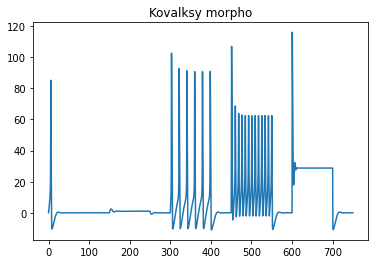

In [13]:
title("Kovalksy morpho")
plot(M.t/ms, M.v[0]/mV)